In [1]:
from auxiliary_functions import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# sklearn transformers
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

## Pipelines utilities
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.pipeline import make_pipeline , make_union
from sklearn.compose import ColumnTransformer
from sklearn import set_config
set_config(display='diagram')

np.random.seed(0)

In [2]:
# Load data and train/test split
raw_data = pd.read_pickle("../Data/enriched_data.pkl")
data_train, data_test = train_test_split(raw_data, test_size=0.20, random_state=0)
y_train = data_train.requester_received_pizza
y_test = data_test.requester_received_pizza

In [3]:
# select the variables of interest for the model
numerical_columns = ['requester_account_age_in_days_at_request', 'requester_days_since_first_post_on_raop_at_request', 
                     'requester_number_of_comments_at_request','requester_number_of_comments_in_raop_at_request', 
                     'requester_number_of_posts_at_request', 'requester_number_of_posts_on_raop_at_request', 
                     'requester_number_of_subreddits_at_request', 'requester_upvotes_minus_downvotes_at_request', 
                     'requester_upvotes_plus_downvotes_at_request', 'request_year', 'request_month', 'request_day', 
                     'request_hour', 'request_weekday', 'request_edit_aware_length', 'has_picture', 'has_link']
text_columns = ['requester_subreddits_at_request_text', 'request_text_edit_aware', 'request_title']

# Baseline model, numerical columns only

In [4]:
# Construct a baseline model without the text features. 
select_numeric = ColumnTransformer([('get_numerical', PassThrough(), numerical_columns)])
baseline_wo_text_clf = Pipeline([('select_numeric', select_numeric), 
                            ('clf', RandomForestClassifier(random_state=0))])
baseline_wo_text_clf = baseline_wo_text_clf.fit(data_train, y_train)

In [5]:
# Estimate the results on the test set
pred_baseline_wo_text = baseline_wo_text_clf.predict_proba(data_test)
fpr_baseline_wo_text, tpr_baseline_wo_text, thresholds = metrics.roc_curve(y_test, pred_baseline_wo_text[:,1])
metrics.auc(fpr_baseline_wo_text, tpr_baseline_wo_text)

0.6519772280101925

# Text feature extaction

## Subreddit feature extraction

In [6]:
# Extract features from subreddits
# Vectorize
subreddit_vectorizer = CountVectorizer(ngram_range=(1, 1), stop_words=None, lowercase=False, 
                                       token_pattern='(?u)[^\s]+', min_df=3) # the token_pattern option enable to split words by sapce only
# Reduce the dimension in a suppervised way with a linear discriminant analysis. 
# Shrinkage option allows regularization of the LDA.
lda_subreddit = LinearDiscriminantAnalysis(n_components=1, shrinkage='auto', solver='eigen') 
subreddit_pipe = make_pipeline(subreddit_vectorizer, DenseTransformer(), lda_subreddit)

## Request title, feature extraction

In [7]:
# Extract features from the request title. Vectorize using CountVectorize and not Tfidf 
# because the vocabulary in the title is elativly short. 
request_title_vectorizer = CountVectorizer(ngram_range=(1, 3), stop_words='english', min_df=3)
# request_title_vectorizer = TfidfVectorizer(smooth_idf=False, ngram_range=(1, 3), stop_words='english', min_df=3)
lda_request_title = LinearDiscriminantAnalysis(n_components=1, shrinkage='auto', solver='eigen')
request_title_pipe = make_pipeline(request_title_vectorizer, DenseTransformer(), lda_request_title)

## Request text feature extration

In [8]:
# Extract 20 topics from the request text
n_topics_text = 20
request_text_edit_aware_vectorizer = TfidfVectorizer(smooth_idf=False, ngram_range=(1, 3), stop_words='english', min_df=3)
nmf_request_text = NMF(init='nndsvd', n_components=n_topics_text, max_iter=500)
request_text_pipe = make_pipeline(request_text_edit_aware_vectorizer, nmf_request_text)

## Text only classifier

In [9]:
all_text_pipe = ColumnTransformer(
        [('subreddit_pipe', subreddit_pipe, 'requester_subreddits_at_request_text'),
        ('request_text_pipe', request_text_pipe, 'request_text_edit_aware'), 
        ('request_title_pipe', request_title_pipe, 'request_title')])

text_clf = RandomForestClassifier()
text_only_clf = Pipeline([('text_feature', all_text_pipe),
                         ('text_clf', text_clf)])
text_only_clf = text_only_clf.fit(data_train, y_train)

In [10]:
pred_text_only = text_only_clf.predict_proba(data_test)
fpr_text_only, tpr_text_only, thresholds = metrics.roc_curve(y_test, pred_text_only[:,1])
metrics.auc(fpr_text_only, tpr_text_only)

0.6007160597361546

# Final classifier with both text and numerical features

In [11]:
features_pipe = ColumnTransformer([('all_text_pipe', all_text_pipe, text_columns), 
                                     ('numerical_pipe', PassThrough(), numerical_columns)])
all_features_clf = Pipeline([('features_pipe', features_pipe), 
                              ('final_clf', RandomForestClassifier(random_state=0))])
all_features_clf = all_features_clf.fit(data_train, y_train)

In [12]:
# The final model pipeline
all_features_clf

Pipeline(steps=[('features_pipe',
                 ColumnTransformer(transformers=[('all_text_pipe',
                                                  ColumnTransformer(transformers=[('subreddit_pipe',
                                                                                   Pipeline(steps=[('countvectorizer',
                                                                                                    CountVectorizer(lowercase=False,
                                                                                                                    min_df=3,
                                                                                                                    token_pattern='(?u)[^\\s]+')),
                                                                                                   ('densetransformer',
                                                                                                    <auxiliary_functions.DenseTransformer object at 0x000001C0F9D2B7F0>),
                                                                                                   ('lineardiscriminantanalys...
                                                   'requester_number_of_posts_on_raop_at_request',
                                                   'requester_number_of_subreddits_at_request',
                                                   'requester_upvotes_minus_downvotes_at_request',
                                                   'requester_upvotes_plus_downvotes_at_request',
                                                   'request_year',
                                                   'request_month',
                                                   'request_day',
                                                   'request_hour',
                                                   'request_weekday',
                                                   'request_edit_aware_length',
                                                   'has_picture',
                                                   'has_link'])])),
                ('final_clf', RandomForestClassifier(random_state=0))])

In [13]:
pred_all_features = all_features_clf.predict_proba(data_test)
fpr_all_features, tpr_all_features, thresholds = metrics.roc_curve(y_test, pred_all_features[:,1])
metrics.auc(fpr_all_features, tpr_all_features)

0.6832967777311874

# Compare results

In [14]:
auc_all_features = cross_val_score(all_features_clf, data_train, y_train, cv=5, scoring='roc_auc')
auc_baseline_wo_text = cross_val_score(baseline_wo_text_clf, data_train, y_train, cv=5, scoring='roc_auc')
auc_text_only = cross_val_score(text_only_clf, data_train, y_train, cv=5, scoring='roc_auc')

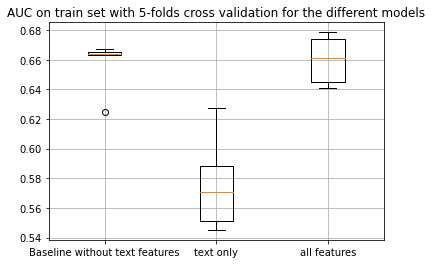

In [15]:
plt.boxplot([auc_baseline_wo_text, auc_text_only, auc_all_features])
plt.grid()
plt.xticks([1,2,3], labels=['Baseline without text features', 'text only', 'all features'])
plt.title('AUC on train set with 5-folds cross validation for the different models')
plt.show()

In [16]:
print(auc_all_features.mean())
print(auc_baseline_wo_text.mean())

0.6597099437188924
0.6568720345714991


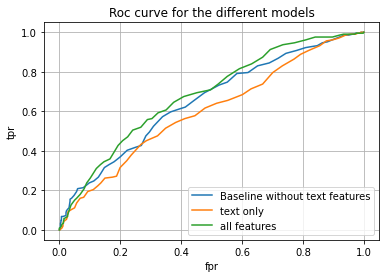

In [17]:
plt.plot(fpr_baseline_wo_text, tpr_baseline_wo_text)
plt.plot(fpr_text_only, tpr_text_only)
plt.plot(fpr_all_features, tpr_all_features)
plt.legend(['Baseline without text features', 'text only', 'all features'])
plt.title('Roc curve for the different models')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.grid()

# Final model

For the final model, we will choose the model with all features even though it gives slightly less stable results. 
We want to limit the false positive rate to 10%. We choose the decision threshold accordingly. 

In [18]:
print(fpr_all_features[20], tpr_all_features[20], thresholds[20])
final_threshold = thresholds[20]

0.10132890365448505 0.2621359223300971 0.42


In [19]:
y_pred = all_features_clf.predict_proba(data_test) >= final_threshold
metrics.confusion_matrix(y_test, y_pred[:,1])

array([[541,  61],
       [152,  54]], dtype=int64)

**Note:** The decision threshold should not have been choosen on the test set but on the training set through a clean cross-validation procedure. We didn't don't it due to a lack of time. 

# Conclusion and way forward

The first feature selected were well chosen and brought meaningfull information. Thus adding pure text features didn't improve the model significantly. Here is some ideas on how to to better : 
* A better pre-processing and vectorization of the text learned on universal database could make a better job than our tf-idf vectorizer learned on our small dataset. (https://radimrehurek.com/gensim/models/word2vec.html). 
* One could thing of using Recurrent neural network (LSTM for exemple) to process the text data. 